## Homework 3 - Which book would you recommend?

-------------

### Importing related libraries

* Importing `functions.py` file to have access to our function

In [2]:
from bs4 import BeautifulSoup
import requests
import lxml
import csv
import re
import os
import pandas as pd
from langdetect import detect
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
import numpy as np
import glob
import pickle
import matplotlib.pyplot as plt
plt.style.use("seaborn")

import functions

------------

**Question:**

## 1. Data collection


### 1.1. Get the list of books


* From [best books ever list](https://www.goodreads.com/list/show/1.Best_Books_Ever?page=1) we want to collect the url associated to each book in the list and retrieve only the urls of the books listed in the first 300 pages.



* The output of this step is a `.txt` file whose single line corresponds to a book's url.

**Comments:**

> Creating a `.txt` file using 2 `for` loops, the first one iterates through the pages (300) and the second one between each book in the chosen page (100). Using `request.get()` and `BeautifulSoup`, we have taken each page, extracted the links and appended them to `url` list. At the end, we have a `.txt` file using the `url` list and each link separated by `\n`.


In [ ]:
#inizialize an empty list
url = []

#for each page, save the corresponding web page, find the anchor elements and save the corresponding tags  
for i in range(300):
    page = requests.get("https://www.goodreads.com/list/show/1.Best_Books_Ever?page="+ str(i + 1))
    soup = BeautifulSoup(page.content, features='lxml')
    tag_a = soup.find_all('a', {"class": "bookTitle"}, itemprop = "url")
    
#for each book, save the corresponding url into the array
    for j in range(0,100):
        url.append("https://www.goodreads.com"+ tag_a[j]['href'])
        
#create a txt file where for each row there is a book's url 
with open("url.txt", 'w') as f:
    f.write("\n".join(map(str, url)))
f.close()

**Question:**

### 1.2. Crawl books

1. Download the html corresponding to each of the collected urls.


2. After you collect a single page, immediatly save its `html` in a file. In this way, if your program stops, for any reason, you will not loose the data collected up to the stopping point.


3. Organize the entire set of downloaded `html` pages into folders. Each folder will contain the `htmls` of the books in page 1, page 2, ... of the list of books.

**Comments:**

> Using the `url.txt` file that we have created in the previous section, reading the lines and then close the file. We have chosen our parent directory `parent_dir` and the child directory `directory`, then have initialized 2 `for` loops to create the folders accordingly and download the `.html` files corresponded on each folder.


* For more info (read the comments in the cell)

In [ ]:
#First we open the url.txt file, reading the lines and then close the file
f = open("url.txt", "r")
lines = f.readlines()
f.close()

#Setting our parent directory and the directory associated with each page number from the list
## PLEASE CHANGE THE PARENT DIRECTORY ACCORDING TO YOUR SYSTEM
parent_dir = "C:/Users/ALL Materials/Data Science - Sapienza/1st Semester/ALGORITHMIC METHODS OF DATA MINING AND LABORATORY/HW3/Links"
directory = "Page_"
page_num = 0


#Looping for 300 times that corresponds to the number of pages
for i in range(300):
    #Incrementing page number according to each page
    page_num += 1
    #Setting the current working directory
    directory = "Page_" + str(page_num)
    #Setting the main path to create the directory
    path = os.path.join(parent_dir, directory)
    #Creating new directory
    os.makedirs(path)
    
    #Looping for 100 times, which is the number of articles per page
    for i in range(100):
        #Selecting the corresponding link
        link = lines[i][:-1]
        #Dowloading the article
        r = requests.get(link, allow_redirects=True)
        #Setting the name file to keep the track
        file_name = "article_" + str(i+1) + ".html"
        #Saving the html file to its corresponding directory
        open(parent_dir + "/" + directory + "/" + file_name, 'wb').write(r.content)

**Question:**

#### 1.3 Parse downloaded pages

At this point, you should have all the html documents about the books of interest and you can start to extract the books informations. The list of information we desire for each book are the following:

1. Title (to save as `bookTitle`)
2. Series (to save as `bookSeries`)
3. Author(s), the first box in the picture below (to save as `bookAuthors`)
4. Ratings, average stars (to save as `ratingValue`)
5. Number of givent ratings (to save as `ratingCount`)
6. Number of reviews (to save as `reviewCount`)
7. The entire plot (to save as `Plot`)
8. Number of pages (to save as `NumberofPages`)
9. Published (Publishing Date)
10. Characters
11. Setting
12. Url

**Comments:**

> Here we have used our custom function `info_parser()` that is available on `functions.py` file. The function takes parent directory (`parent_dir`), number of pages (`pages`) that is default to (`300`), the folder that (`.tsv`) files will be stored (`tsv_articles`), the folder to that `.html` files are stored (`links`) and the name of `.txt` file that our links are stored (`links`) as the inputs, then the function extracts books information, check them with `langdetect` library to be sure that the `Plot` exists and it's in English and at the end, creates the `.tsv` files in `/tsv_articles`.

* For more info (read the docstrings and comments in the function)

In [ ]:
## Custom function designed to 
parent_dir = "C:/Users/ALL Materials/Data Science - Sapienza/1st Semester/ALGORITHMIC METHODS OF DATA MINING AND LABORATORY/HW3/Links"

functions.info_parser(parent_dir, pages=300, tsv_articles= "tsv_articles", links= "Links", url= 'url')

All tsv files generated sucessfully in tsv_articles directory

--------------

**Question:**

## 2. Search Engine

Now, we want to create two different Search Engines that, given as input a query, return the books that match the query.

First, you must pre-process all the information collected for each book by :


1. Removing stopwords
2. Removing punctuation
3. Stemming
4. Anything else you think it's needed


For this purpose, you can use the [nltk](https://www.nltk.org/) library.

**Commnets:**
> For this question, we have chosen a different approach, that is to load all the `.tsv` files into one `.csv` file. Therefore, we prevent unnecessary processes and save time. The function `create_csv()` takes parent directory `parent_dir` and `tsv_folder` and the variable `export_csv` that its default value is `True` and export the file `combined_csv.csv` into `files` directory.

* For more info (read the docstrings and comments in the function)

*Here we first create and read the dataframe*

In [ ]:
#Creating a .csv files out of all .tsv files

parent_dir = "C:/Users/engme/OneDrive/Desktop/ALL Materials/Data Science - Sapienza/1st Semester/ALGORITHMIC METHODS OF DATA MINING AND LABORATORY/Labs/6"
tsv_folder = "tsv_articles"

# The function to create .csv file

df_tsv = functions.create_csv(parent_dir, tsv_folder, export_csv= True)

> For further needs of the file, we can read it with `pd.read_csv`

In [3]:
#Reading the created .csv file
df_tsv = pd.read_csv("files/combined_csv.csv")

**Question:**

### 2.1. Conjunctive query

For the first version of the search engine, we narrow our interest on the `Plot` of each document. It means that you will evaluate queries only with respect to the book's plot.

#### 2.1.1) Create your index!

Before building the index,
Create a file named `vocabulary`, in the format you prefer, that maps each word to an integer (`term_id`).

**Comments:**

> In order to create our vocabulary dictionary (`vocabulary`) , processed text documents (`processed_docs`) and first inverted index for this exercise (`inv_index1`), we have created a custom function `create_dictionary_plot()` that takes our dataframe (`df_tsv`) that we have created in previous section and `export_pickle` to whether export the `pickle` files for aforementioned dictionaries that its value is set `True` as default.

* For more info (read the docstrings and comments in the function)

In [ ]:
# Creating the inverted index and vocabulary dictionaries

inv_index1, vocabulary, processed_docs = functions.create_dictionary_plot(df_tsv, export_pickle = True)

> After that we can easily import our files, without much issue for further usage.

In [4]:
# Loading the saved dictionaries
with open("files/dict_file", "rb") as input_file:
    inv_index1 = pickle.load(input_file)
    input_file.close
    
with open("files/voc_file", "rb") as input_file:
    vocabulary = pickle.load(input_file)
    input_file.close
    
with open("files/doc_file", "rb") as input_file:
    processed_docs = pickle.load(input_file)
    input_file.close

**Question:**

#### 2.1.2) Execute the query

Given a query, that you let the user enter, the Search Engine is supposed to return a list of documents.

> What documents do we want?

Since we are dealing with conjunctive queries (AND), each of the returned documents should contain all the words in the query. The final output of the query must return, if present, the following information for each of the selected documents:

* `bookTitle`
* `Plot`
* `Url`

<br>


**Comments:**

> For the Search Engine we have created a custom function `Search_Engine1()` that takes the user query (`query`), the dataframe of our books (`df_tsv`), the vocabulary dictionary (`vocabulary`), the first inverted index dictionary (`inv_index1`) and the number of results (`results`) that the user wants to view, and its default value is `10`.

* For more info (read the docstrings and comments in the function)

In [10]:
query = input("Please Enter your query: ")
functions.Search_Engine1(query, df_tsv, vocabulary, inv_index1, results= 10)

Please Enter your query: hunger games


,bookTitle,Plot,Url
3156,Guardian,The pulse-pounding sequel to Proxy! Inspired b...,https://www.goodreads.com/book/show/2767052-th...
23228,Mystic City,"For fans of Matched, The Hunger Games, X-Men,...",https://www.goodreads.com/book/show/18405.Gone...
19047,The Hunger Games Tribute Guide,The New York Times bestselling Hunger Games is...,https://www.goodreads.com/book/show/22628.The_...
9230,Delicate Devastation,"The Endurers - Alpha, immortal men that have g...",https://www.goodreads.com/book/show/345627.Vam...
22331,The Ballad of Songbirds and Snakes,It is the morning of the reaping that will kic...,https://www.goodreads.com/book/show/149267.The...
23047,Gregor and the Prophecy of Bane,The action and adventure continue for Gregor i...,https://www.goodreads.com/book/show/2998.The_S...
19565,Mockingjay,The final book in the ground-breaking HUNGER G...,https://www.goodreads.com/book/show/18144590-t...
23630,Devoured,Sienna Jensen had no plans to return home when...,https://www.goodreads.com/book/show/4473.A_Pra...
159,Eeny Meeny,"The ""dark, twisted, thought-provoking"" (#1 New...",https://www.goodreads.com/book/show/2998.The_S...
5242,The Trap,"From author Andrew Fukuda comes The Trap, th...",https://www.goodreads.com/book/show/170448.Ani...


**Question:**

### 2.2) Conjunctive query & Ranking score

For the second search engine, given a query, we want to get the top-k (the choice of k it's up to you!) documents related to the query. In particular:

* Find all the documents that contains all the words in the query.
* Sort them by their similarity with the query
* Return in output k documents, or all the documents with non-zero similarity with the query when the results are less than k. You must use a heap data structure (you can use Python libraries) for maintaining the top-k documents.

To solve this task, you will have to use the tfIdf score, and the Cosine similarity. The fielf to consider it is still the plot. Let's see how.

**2.2.1) Inverted index**

Your second Inverted Index must be of this format:

`{
term_id_1:[(document1, tfIdf_{term,document1}), (document2, tfIdf_{term,document2}), (document4, tfIdf_{term,document4}), ...],
term_id_2:[(document1, tfIdf_{term,document1}), (document3, tfIdf_{term,document3}), (document5, tfIdf_{term,document5}), (document6, tfIdf_{term,document6}), ...],
...}`

Practically, for each word you want the list of documents in which it is contained in, and the relative `tfIdf` score.

Tip: `tfIdf` values are invariant with respect to the query, for this reason you can precalculate them.


**Comments:**

> In order to generate the the second inverted index dictionary (`inv_index2`), we have created a custom function `create_invert_index2()` that takes the number of entries in our dataframe (`len(df_tsv)`), the first inverted index dictionary (`inv_index1`) and `export_pickle` to whether export the `pickle` file that its default value is set to `True`.


> For creating the Cosine Similarity dictionary we have another function named `create_similarity_dictionary` that takes the second inverted index dictionary (`inv_index2`) that we have created in the previous function, plus `export_pickle` to whether export the `pickle` file that its default value is set to `True`.

* For more info (read the docstrings and comments in the function)

In [ ]:
inv_index2 = functions.create_invert_index2(len(df_tsv), inv_index1, processed_docs, export_pickle = True)

dictSimilarity = functions.create_similarity_dictionary(inv_index2, export_pickle = True)

> Now we can import our file for further usage without an issue.

In [5]:
with open("files/dictsim_file", "rb") as input_file:
    dictSimilarity = pickle.load(input_file)
    input_file.close

with open("files/inv2_file", "rb") as input_file:
    inv_index2 = pickle.load(input_file)
    input_file.close

**Question:**

**2.2.2) Execute the query**

In this new setting, given a query you get the right set of documents (i.e., those containing all the words in the query) and sort them according to their similairty to the query. For this purpose, as scoring function we will use the Cosine Similarity with respect to the tfIdf representations of the documents.

The search engine is supposed to return a list of documents, ranked by their Cosine Similarity with respect to the query entered in input.

>More precisely, the output must contain:

* `bookTitle`
* `Plot`
* `Url`
* The similarity score of the documents with respect to the query

<br>

**Comments:**

> For the second Search Engine, we have created a custom function (`Search_Engine2()`) to search through the `Plots` of the book and scoring function we will use the Cosine Similarity with respect to the tfIdf representations of the documents. The function takes the user's query (`query`), the dataframe of books (`df_tsv`), the first inverted index dictionary (`inv_index1`), the second inverted index dictionary (`inv_index2`), the similarity dictionary (`dictSimilarity`), vocabulary dictionary (`vocabulary`) and the number of results (`results` Default set to `10`) as inputs and search for the best matches according to Cosine Similarity, normalized and sort the findings based on the score.


* For more info (read the docstrings and comments in the function)

> Here we try the same query as before

In [12]:
query = input("Enter your query: ")
functions.Search_Engine2(query, df_tsv, inv_index1, inv_index2, dictSimilarity, vocabulary, results= 10)

Enter your query: hunger games


,bookTitle,Plot,Url,Similarity
19047,The Hunger Games Tribute Guide,The New York Times bestselling Hunger Games is...,https://www.goodreads.com/book/show/22628.The_...,1.00
8747,The Hunger Games Trilogy Boxset,"The extraordinary, ground breaking New York Ti...",https://www.goodreads.com/book/show/252577.Ang...,0.60
2339,Throne of Glass Collection,"Perfect for the Fans of Hunger Games, Game Of ...",https://www.goodreads.com/book/show/231804.The...,0.37
21715,"SAMPLER ONLY: Catching Fire (The Hunger Games,...","Against all odds, Katniss Everdeen has won the...",https://www.goodreads.com/book/show/6288.The_Road,0.36
21151,The Hunger Games: Official Illustrated Movie C...,Go behind the scenes of the making of The Hung...,https://www.goodreads.com/book/show/231804.The...,0.36
19565,Mockingjay,The final book in the ground-breaking HUNGER G...,https://www.goodreads.com/book/show/18144590-t...,0.34
0,The Hunger Games,"Could you survive on your own in the wild, wit...",https://www.goodreads.com/book/show/2767052-th...,0.26
16630,The Dust Lands Trilogy: Blood Red Road; Rebel ...,All three books in the highly praised Dust Lan...,https://www.goodreads.com/book/show/12232938-t...,0.26
23432,Catching Fire: The Official Illustrated Movie ...,"Catching Fire, the New York Times bestseller b...",https://www.goodreads.com/book/show/11127.The_...,0.26
25008,Ruins,"Kira, Samm, and Marcus fight to prevent a fina...",https://www.goodreads.com/book/show/24280.Les_...,0.21


--------------------

**Question:**

## 3. Define a new score!

Now it's your turn. Build a new metric to rank books based on the queries of their users.

In this scenario, a single user can give in input more information than the single textual query, so you need to take into account all this information, and think a creative and logical way on how to answer at user's requests.

Practically:

The user will enter you a text query. As a starting point, get the query-related documents by exploiting the search engine of Step 3.1.

Once you have the documents, you need to sort them according to your new score. In this step you won't have anymore to take into account just the `plot` of the documents, you **must** use the remaining variables in your dataset (or new possible variables that you can create from the existing ones...). You **must** use a heap data structure (you can use Python libraries) for maintaining the *top-k* documents.

>Q: How to sort them? A: Allow the user to specify more information, that you find in the documents, and define a new metric that ranks the results based on the new request.

**N.B.**: You have to define a **scoring function**, not a filter!


The output, must contain:

* `bookTitle`
* `Plot`
* `Url`
* The similarity score of the documents with respect to the query

**Comments:**

> For the new Search Engine, we have created a custom function `` that takes the user's query (`query`), the dataframe of books (`df_tsv`), the first inverted index dictionary (`inv_index1`), the second inverted index dictionary (`inv_index2`), vocabulary dictionary (`vocabulary`) and the number of results (`results` Default set to `10`) as inputs, and to return the set of books based on new scoring function by asking about more information about the books from the user, we have used number of pages `NumberofPages` as one scoring method, and we have created a new feature that is the year of publication from `Published` column. The results are sorted based on `Similarity` that has been defined using the new scoring function.


* For more info (read the docstrings and comments in the function)

> Here we try the same query as before

In [13]:
query = input("Enter your query: ")
functions.Search_Engine_NewScore(query, df_tsv, inv_index1, inv_index2, vocabulary, results= 10)

Enter your query: hunger games
Do you want to use our new scoring method? [Y/N] :y
How many pages does your desired book have? (approximately) ->370
What year does the book published? (approximately) ->2008


,bookTitle,Plot,Url,Similarity
book_index,,,,
0,The Hunger Games,"Could you survive on your own in the wild, wit...",https://www.goodreads.com/book/show/2767052-th...,1.00
12312,Catching Fire,SPARKS ARE IGNITING.<br/>FLAMES ARE SPREADING....,https://www.goodreads.com/book/show/7624.Lord_...,0.95
19565,Mockingjay,The final book in the ground-breaking HUNGER G...,https://www.goodreads.com/book/show/18144590-t...,0.91
13717,Best Served Cold,Springtime in Styria. And that means war. Spri...,https://www.goodreads.com/book/show/4934.The_B...,0.89
15722,Cheating on My Mistress,Carmelo Miller is a retired NBA player who has...,https://www.goodreads.com/book/show/17245.Dracula,0.89
23047,Gregor and the Prophecy of Bane,The action and adventure continue for Gregor i...,https://www.goodreads.com/book/show/2998.The_S...,0.85
1084,Glow,One of School Library Journal ’s Best Fictio...,https://www.goodreads.com/book/show/10210.Jane...,0.85
3719,Crossing the Seas: A Diary of My Thoughts,"About the book (A teaser) ""Crossing the Seas: ...",https://www.goodreads.com/book/show/76620.Wate...,0.82
23228,Mystic City,"For fans of Matched, The Hunger Games, X-Men,...",https://www.goodreads.com/book/show/18405.Gone...,0.82


------------

**Question:**

## 4. Make a nice visualization!

Our goal is to quantify and visualize the writers' production.

1. Consider the first 10 BookSeries in order of appearance.
2. Build a 2-d plot where the x-axis is the years since publication of the first book (starting from 0), and y-axis there must be the cumulative series page count (all the Series start from (0,num_pages) point, which represents the first book). Since we want the cumulative number of page, the y-axis value of each book is added to the previous point.


<br>


**Comments:**

> Because we want to use with `bookSeries`, `Published` and `NumberofPages` we will drop the `NaN` values according to these columns and reset our indexes for better iteration.
We extract the number of pages and year of publication from `NumberofPages` and `Published`, respectively. Adding the new columns to our dataframe `Year` and `Pages`. Considering the list first 10 book series in our dataframe, and extract their information based on what we need to visualization and create our dictionary `tempDict`, which its keys are the book series (e.g. `The Hunger Games`, `From "A Journal of Love"`, etc.) and its values are a list of lists that their values are `index`, `bookTitle`, `Pages` and `Year`. Example : `[0, 'The Hunger Games #1', 374, 2008]`

<br>

>Here let's take a look at the dictionary:

In [14]:
df_tsv.dropna(subset=['bookSeries', 'Published', 'NumberofPages'], inplace = True)
df_tsv.reset_index(drop = True, inplace=True)

intYear = []
numPages = []
for i in range(len(df_tsv)):
    year = int(re.findall(r'\d\d\d\d', df_tsv["Published"][i])[0])
    intYear.append(year)
    num = int(re.findall(r'\d+', df_tsv["NumberofPages"][i])[0])
    numPages.append(num)

df_tsv["Year"] = intYear
df_tsv["Pages"] = numPages

bookSeriesList = []
for i in range(10):
    bookS = df_tsv["bookSeries"][i][:-3]
    bookSeriesList.append(bookS)

tempDict = {}
mainList = []
bookList = []

for i in range(len(bookSeriesList)):
    for j in range(len(df_tsv)):
        for k in range(10):
            mybook = bookSeriesList[i] + " #" + str(k + 1)
            dfbook = df_tsv["bookSeries"][j]
            if mybook == dfbook:
                bookList.append(j)
                bookList.append(mybook)
                bookList.append(df_tsv["Pages"][j])
                bookList.append(df_tsv["Year"][j])
                mainList.append(bookList)
                bookList = []
                
    tempDict[bookSeriesList[i]] = mainList
    mainList = []


tempDict

{'The Hunger Games': [[0, 'The Hunger Games #1', 374, 2008],
  [5448, 'The Hunger Games #2', 391, 2009],
  [8376, 'The Hunger Games #3', 390, 2010]],
 'From "A Journal of Love"': [[1, 'From "A Journal of Love" #1', 304, 1990]],
 'Ramona Quimby': [[2, 'Ramona Quimby #4', 160, 2000],
  [264, 'Ramona Quimby #3', 160, 2000],
  [3397, 'Ramona Quimby #7', 150, 1996],
  [3525, 'Ramona Quimby #1', 160, 2000],
  [10908, 'Ramona Quimby #2', 192, 2000],
  [11854, 'Ramona Quimby #6', 190, 1982]],
 'Great Plains Trilogy': [[3, 'Great Plains Trilogy #2', 417, 1983],
  [2992, 'Great Plains Trilogy #1', 159, 1992],
  [6716, 'Great Plains Trilogy #3', 314, 2009],
  [8789, 'Great Plains Trilogy #3', 232, 2000]],
 'Jaded': [[4, 'Jaded #1', 293, 2011], [1998, 'Jaded #2', 264, 2013]],
 'The Traitor Son Cycle': [[5, 'The Traitor Son Cycle #1', 650, 2012]],
 'The Secret Life of Amy Bensen': [[6,
   'The Secret Life of Amy Bensen #1',
   250,
   2013],
  [5335, 'The Secret Life of Amy Bensen #3', 384, 2015],


**Comments:**

> After that, we will create the dictionary that we need (`cumulativeBooks`) that its keys are `Years` and the values are `Pages`. The first step is to sort the dictionary and add the values accordingly to create the cumulative number of pages based on years of publication.

* Let's take a look at our dictionary `sortedCumulativeBooks`

In [15]:
cumulativeBooks = {}
for i in tempDict:
    for j in tempDict[i]:
        if j[3] not in cumulativeBooks:
            cumulativeBooks[j[3]] = j[2]
        else:
            temp = cumulativeBooks[j[3]]
            temp += j[2]
            cumulativeBooks[j[3]] = temp
sortedCumulativeBooks = {}

for key in sorted(cumulativeBooks):
    sortedCumulativeBooks[key] = cumulativeBooks[key]

pag = 0
for key in sortedCumulativeBooks:
    pag += sortedCumulativeBooks[key]
    sortedCumulativeBooks[key] = pag


sortedCumulativeBooks

{1982: 190,
 1983: 607,
 1990: 911,
 1992: 1070,
 1996: 1220,
 2000: 2124,
 2002: 4062,
 2008: 4436,
 2009: 5141,
 2010: 6160,
 2011: 6453,
 2012: 8062,
 2013: 9114,
 2014: 10280,
 2015: 10664,
 2016: 11368}

> In the last stage we have visualized our dictionary :

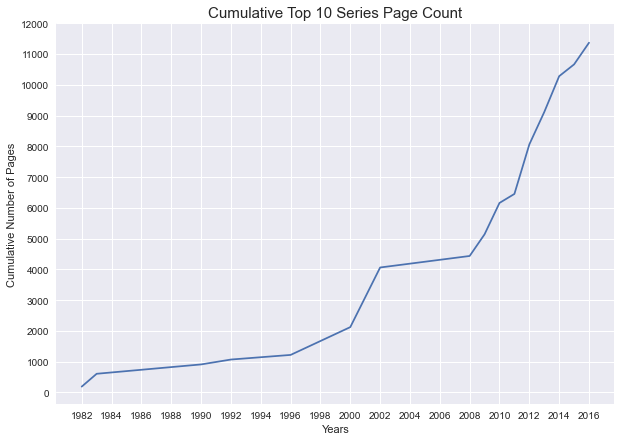

In [16]:
plt.figure(figsize = (10,7))
plt.plot(sortedCumulativeBooks.keys(), sortedCumulativeBooks.values())
plt.title("Cumulative Top 10 Series Page Count", fontsize = 15);
plt.xlabel("Years")
plt.ylabel("Cumulative Number of Pages")
plt.xticks(ticks=np.arange(1982,2018, 2))
plt.yticks(ticks=np.arange(0,13000, 1000))
plt.show();

------------

**Question:**

## 5. Algorithmic Question

You are given a string written in english capital letters, for example S="CADFECEILGJHABNOPSTIRYOEABILCNR." You are asked to find the maximum length of a subsequence of characters that is in alfabetical order. For example, here a subsequence of characters in alphabetical order is the "ACEGJSTY": "C**A**DFE**CE**IL**GJ**HABNOFP**ST**IR**Y**OEABILCNR." Among all the possible such sequences, you are asked to find the one that is the longest.

Define as X[i] = "the length of the longest sequence of characters in alphabetical order that terminates at the i-th character". One can prove that:

`X[i] = 1 + max{X[j]; j = 0, ..., i-1, such that S[j]<S[i]}`

`X[i] = 1, if there does not exist such a j.`

1. Write a recursive program that, given a string, computes the length of the subsequence of maximum length that is in alphabetical order. Try some examples. Are the examples of short strings correct? Can you find examples that your algorithm does not terminate in reasonable time?

In [6]:
String_input = "CADFECEILGJ"

n = len(String_input) 
print("Length of sequence is", functions.recur_call(String_input) )

Length of sequence is 5


**Comments:**
> I tried to take both inputs having short and long string and it's worked on both cases. 
I tried with long input string and it's run a bit long but didn't terminate but I am not sure about how long I would need to wait to check terminate condition

**Question:**

2. Show that the running time of the algorithm is exponential. <br>


**Answer:**

> If we see the logic of this recursion method which is overlapping and stack is getting used, so i believe this algorithm is exponential

**Question:**

3. Write a program that computes the length of the subsequence of maximum length, using dynamic programming.

In [7]:
#Dynamic programming 

alphabet={"A":1,"B":2,"C":3,"D":4,"E":5,"F":6,"G":7,"H":8,"I":9,"J":10,"K":11,"L":12,"M":13,"N":14,"O":15,"P":16,"Q":17,"R":18,"S":19,"T":20,"U":21,"V":22,"W":23,"X":24,"Y":25,"Z":26}
maxx = functions.find_longest_subsequence(String_input, alphabet)
print("length of the longest sequence of characters in alphabetical order: ",len(maxx))


length of the longest sequence of characters in alphabetical order:  5


**Question:**

4. What is its runtime complexity? <br>

**Answer:**

We have used here inner loop so it's Runtime complexity is O(n^2)

--------------------

**Question:**

## BONUS

Prove that the formula for X[i] given above is correct.

**Answer:**

>Define as $X[i]$ = "the length of the longest sequence of characters in alphabetical order that
terminates at the i-th character". One can prove that
$X[i] = 1 + max{X[j]; j = 0, ..., i-1, \ni S[j]<S[i]}$
$X[i] = 1$, if there does not exist such a $j$ .

>As per our understanding, length of max longest sequence will be $i$ and other subsequences will be $i-1$ so $x[i] = max+1$
